In [1]:
import linalg
import data
import vcl
import vcalg
import vpm
import segyvc
import rsfvc
import asg
import os
import awi

# bulk modulus with lens
data.model(bulkfile='m.rsf', bulk=4.0, nx=401, nz=201,
                   dx=20, dz=20, lensfac=0.7)

# homogeneous bulk modulus 
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201,
                   dx=20, dz=20, lensfac=1.0)

# construct bulk modulus space (domain of modeling operator)
bulksp = rsfvc.Space('m.rsf')

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,
                    f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
linalg.scale('wstar.su',1.0e+3)
    
# create zero data file with same source position, rz=500, rx=[2000,6000]
# use it to define data space
data.rechdr(file='g.su',nt=626,dt=8.0,ntr=201,
                    rx=2000.0,rz=1000.0,sx=4200,sz=3000,drx=20.0)
datasp = segyvc.Space('g.su')
    
# construct SU file with same spatial geometry, time range -1 < t < 1 s, 
# for adaptive kernels (extended source)
data.rechdr(file='baru.su',nt=251,dt=8.0,\
              ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20,delrt=-1000)
usp=segyvc.Space('baru.su')    

# construct product domain and range
dom = vcl.ProductSpace([bulksp,usp])
rng = vcl.ProductSpace([datasp,usp])

# construct FD simulator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bym.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)

print('...')

# compute data traces, corresponding to lens model
m = vcl.Vector(bulksp,'m.rsf')
d = vcl.Vector(rng)
d[0].copy(F(m))

# homog model
m0 = vcl.Vector(bulksp,'m0.rsf')

# test bulkmod
mt = vcl.Vector(bulksp)

# sample t in [0,1]
tval = []
for i in range(11):
    tval.append(float(i)/10.0)
    
# construct CG solver for internal AWI use
#sol = vcalg.cgne(kmax=20, eps=0.01, rho=0.01, verbose=0)
sol = vcalg.cgne(kmax=200, eps=0.0001, rho=0.0001, verbose=0)

sep = awi.awisep(dom, rng, F, alpha=0.0, awisol=sol, observed=d[0])

jval00 = []

print('\n alpha=0.0')
print('  t         j')
for i in range(11):
    mt.copy(m)
    mt.linComb(1.0-tval[i],m0,tval[i])
    j = vpm.vpmjet(mt, sep, d, sol)
    jval00.append(j.value())
    print('%6.2f     %10.4e' % (tval[i], jval00[i]))
    
alpha = 4.0e-4
jval = []

for k in range(5):
    sep = awi.awisep(dom, rng, F, alpha=alpha, awisol=sol, observed=d[0])
    jv=[]
    print('\n alpha=' + str(alpha))
    print('  t         j')
    for i in range(11):
        mt.copy(m)
        mt.linComb(1.0-tval[i],m0,tval[i])
        j = vpm.vpmjet(mt, sep, d, sol)
        jv.append(j.value())
        print('%6.2f     %10.4e' % (tval[i], jv[i]))
    jval.append(jv)
    alpha = 0.5*alpha
    

...

 alpha=0.0
  t         j
  0.00     2.3923e-07
  0.10     2.3748e-07
  0.20     2.4419e-07
  0.30     2.6241e-07
  0.40     2.6213e-07
  0.50     2.5850e-07
  0.60     2.3449e-07
  0.70     2.2748e-07
  0.80     2.2152e-07
  0.90     2.3078e-07
  1.00     3.0618e-07

 alpha=0.0004
  t         j
  0.00     2.6719e-02
  0.10     2.3924e-02
  0.20     2.1115e-02
  0.30     1.8279e-02
  0.40     1.5398e-02
  0.50     1.2507e-02
  0.60     9.6566e-03
  0.70     6.9329e-03
  0.80     4.4849e-03
  0.90     2.5041e-03
  1.00     1.1143e-03

 alpha=0.0002
  t         j
  0.00     1.0110e-02
  0.10     8.7951e-03
  0.20     7.5205e-03
  0.30     6.2894e-03
  0.40     5.1049e-03
  0.50     3.9894e-03
  0.60     2.9635e-03
  0.70     2.0515e-03
  0.80     1.2862e-03
  0.90     7.0277e-04
  1.00     3.1985e-04

 alpha=0.0001
  t         j
  0.00     3.1313e-03
  0.10     2.6810e-03
  0.20     2.2547e-03
  0.30     1.8535e-03
  0.40     1.4785e-03
  0.50     1.1356e-03
  0.60     8.2988e-04
  0

Text(0.5, 1.0, 'AWI-VPM objective minus J0 scaled by alpha^-2\nred: alpha=0.0004\ngreen: alpha=0.0002\nblue: alpha=0.0001\nyellow: alpha=0.00005\nblack: alpha=0.000025\nkmax=200 eps=0.0001 rho=0.0001')

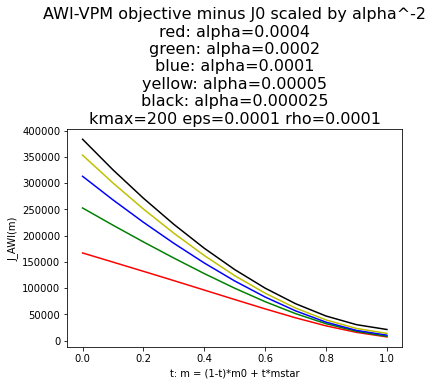

In [3]:
import matplotlib.pyplot as plt
i=0
alpha=4.e-4
#plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow', 'black'])
cols=['r', 'g', 'b', 'y', 'k']

for i in range(5):
    beta=1.0/(alpha*alpha)
    sval=[]
    for j in range(11):
        sval.append(beta*(jval[i][j]-jval00[j]))
    plt.plot(tval,sval,color=cols[i])
    alpha=0.5*alpha

plt.xlabel('t: m = (1-t)*m0 + t*mstar')
plt.ylabel('J_AWI(m)')
plt.title('AWI-VPM objective minus J0 scaled by alpha^-2\nred: alpha=0.0004\ngreen: alpha=0.0002\nblue: alpha=0.0001\nyellow: alpha=0.00005\nblack: alpha=0.000025\nkmax=200 eps=0.0001 rho=0.0001', fontsize=16)